# N-HiTS

In [ ]:
pip install darts

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tensorflow.keras.layers import MaxPool1D

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (9,6)

In [5]:
df = pd.read_csv('/content/data.csv')

df.head()

date_time  traffic_volume
0  9/29/2016 17:00          5551.0
1  9/29/2016 18:00          4132.0
2  9/29/2016 19:00          3435.0
3  9/29/2016 20:00          2765.0
4  9/29/2016 21:00          2443.0

<Axes: xlabel='date_time'>

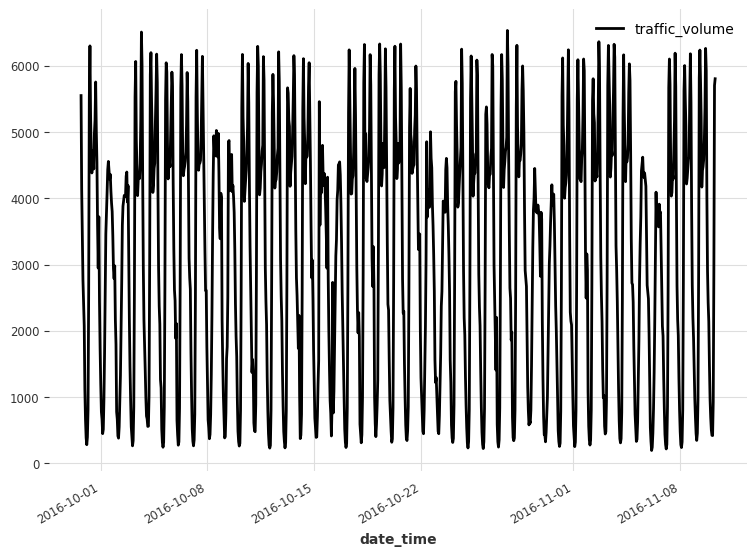

In [6]:
series = TimeSeries.from_dataframe(df, time_col='date_time')

series.plot()

<Axes: xlabel='date_time'>

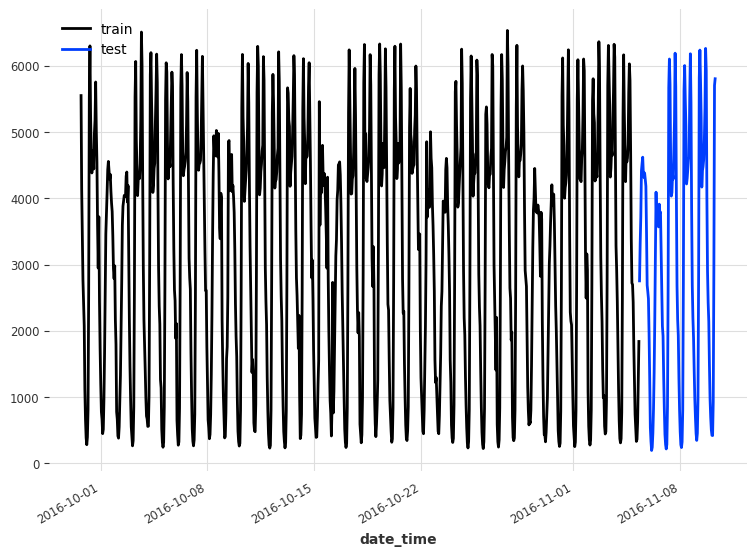

In [7]:
train, test = series[:-120], series[-120:]

train.plot(label='train')
test.plot(label='test')

## Baseline

In [8]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=168)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(120)

<Axes: xlabel='date_time'>

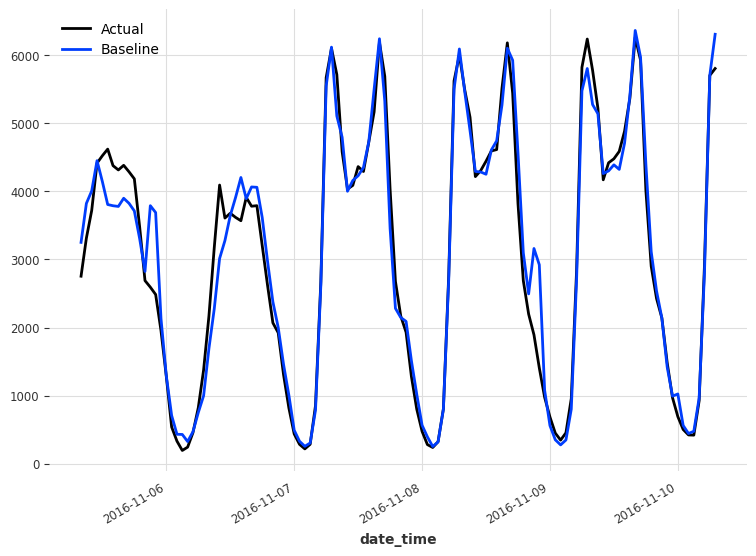

In [9]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')

In [10]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)

print(naive_mae)

249.09166666666667


### Demonstrate MaxPool

In [11]:
maxpool_l4 = MaxPool1D(pool_size=4, strides=1, padding='same')
maxpool_l12 = MaxPool1D(pool_size=12, strides=1, padding='same')
maxpool_l24 = MaxPool1D(pool_size=24, strides=1, padding='same')

x = df['traffic_volume'].values
x = tf.reshape(x, [1, len(x), 1])

x_maxpooled_l4 = maxpool_l4(x).numpy().flatten()
x_maxpooled_l12 = maxpool_l12(x).numpy().flatten()
x_maxpooled_l24 = maxpool_l24(x).numpy().flatten()


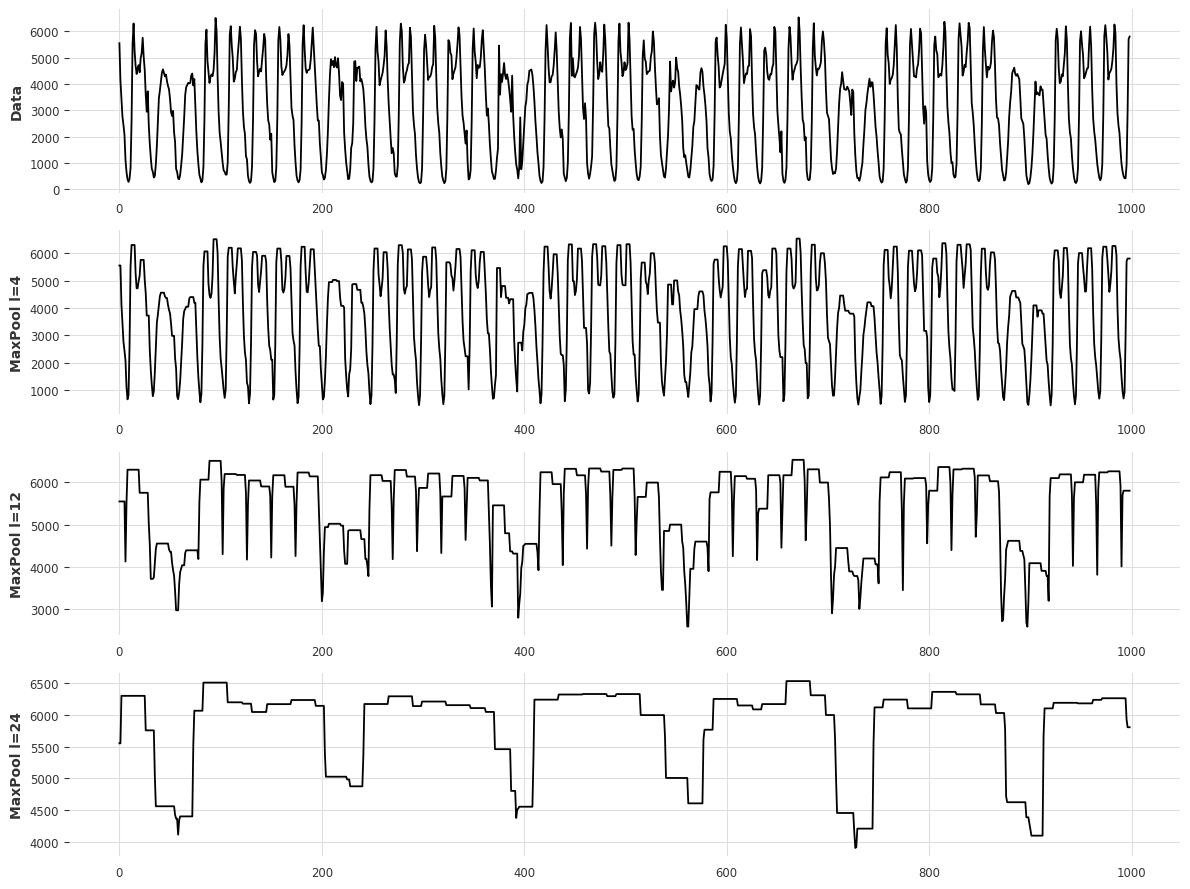

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12,9))

ax1.plot(df['traffic_volume'])
ax1.set_ylabel('Data')

ax2.plot(x_maxpooled_l4)
ax2.set_ylabel('MaxPool l=4')

ax3.plot(x_maxpooled_l12)
ax3.set_ylabel('MaxPool l=12')

ax4.plot(x_maxpooled_l24)
ax4.set_ylabel('MaxPool l=24')

plt.tight_layout()

## Apply N-HiTS

In [13]:
from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nhits = NHiTSModel(
    input_chunk_length=168,
    output_chunk_length=120,
    random_state=42)

nhits.fit(
    scaled_train,
    epochs=50)

scaled_pred_nhits = nhits.predict(n=120)
pred_nhits = train_scaler.inverse_transform(scaled_pred_nhits)

mae_nhits = mae(test, pred_nhits)

print(mae_nhits)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
970 K     Trainable params
86.2 K    Non-trainable params
1.1 M     Total params
4.228     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

267.73385554141566


<Axes: xlabel='date_time'>

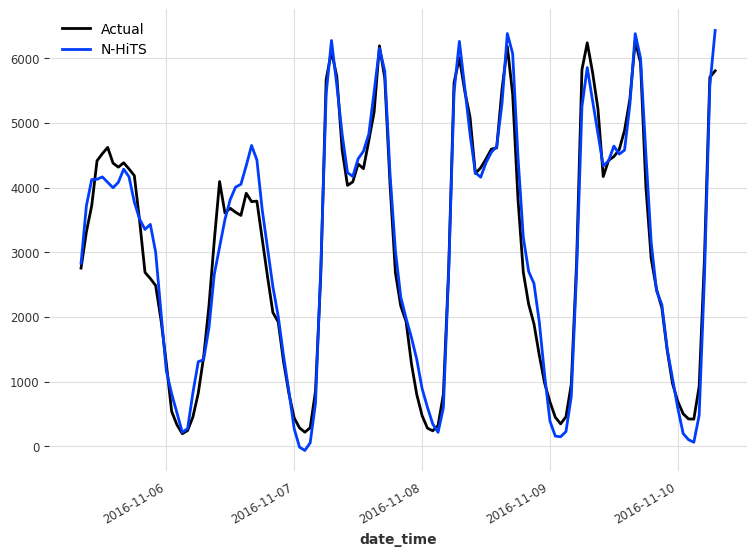

In [14]:
test.plot(label='Actual')
pred_nhits.plot(label='N-HiTS')

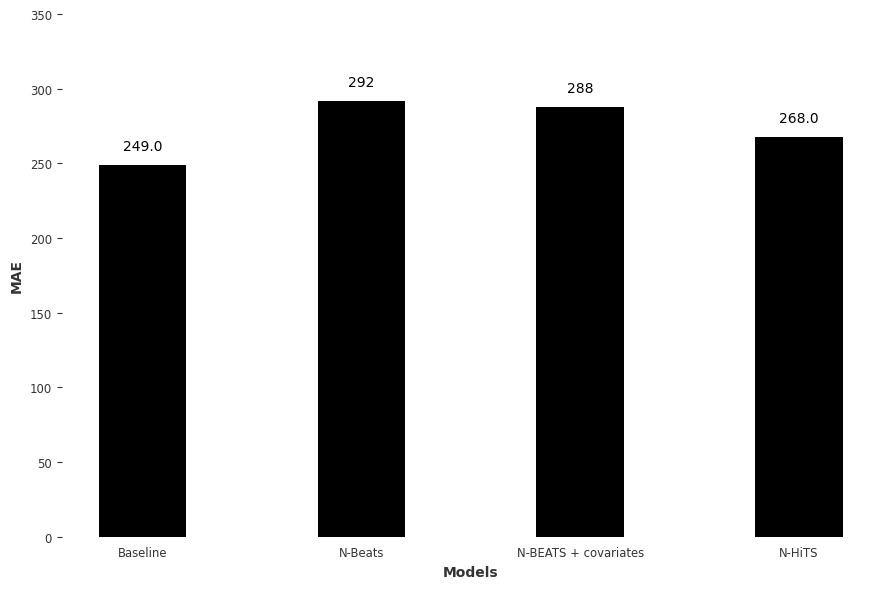

In [16]:
fig, ax = plt.subplots()

# took the numbers from the N-BEATS testing
x = ['Baseline', 'N-Beats', 'N-BEATS + covariates', 'N-HiTS']
y = [naive_mae, 292, 288, mae_nhits]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.set_ylim(0, 350)
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 10, s=str(round(value,0)), ha='center')

plt.tight_layout()